<a href="https://colab.research.google.com/github/dajebbar/FreeCodeCamp-python-data-analysis/blob/main/simpleImputeModifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import os

od.version()
url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
od.download(url)


data_dir = 'weather-dataset-rattle-package'

os.listdir(data_dir)
train_csv = data_dir + '/weatherAUS.csv'

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
raw_df = pd.read_csv(train_csv)

categorical_column = ['Location','WindGustDir', 'WindDir9am', 
                      'WindDir3pm',  'RainToday']
numerical_column = ['MinTemp', 'MaxTemp', 'Sunshine', 'WindSpeed9am', 
                    'Pressure3pm', 'Temp9am', 'Temp3pm', 'Cloud3pm',
                    'Rainfall', 'Evaporation', 'WindGustSpeed', 'Cloud9am' ]

target_column = 'RainTomorrow'
year = pd.to_datetime(raw_df.Date).dt.year
date = 'Date'

df = raw_df[categorical_column + numerical_column + [target_column]]
df.head()

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,MinTemp,MaxTemp,Sunshine,WindSpeed9am,Pressure3pm,Temp9am,Temp3pm,Cloud3pm,Rainfall,Evaporation,WindGustSpeed,Cloud9am,RainTomorrow
0,Albury,W,W,WNW,No,13.4,22.9,NaN,20.0,1007.1,16.9,21.8,NaN,0.6,NaN,44.0,8.0,No
1,Albury,WNW,NNW,WSW,No,7.4,25.1,NaN,4.0,1007.8,17.2,24.3,NaN,0.0,NaN,44.0,NaN,No
2,Albury,WSW,W,WSW,No,12.9,25.7,NaN,19.0,1008.7,21.0,23.2,2.0,0.0,NaN,46.0,NaN,No
3,Albury,NE,SE,E,No,9.2,28.0,NaN,11.0,1012.8,18.1,26.5,NaN,0.0,NaN,24.0,NaN,No
4,Albury,W,ENE,NW,No,17.5,32.3,NaN,7.0,1006.0,17.8,29.7,8.0,1.0,NaN,41.0,7.0,No


In [5]:
df[numerical_column].isna().sum()

MinTemp           1485
MaxTemp           1261
Sunshine         69835
WindSpeed9am      1767
Pressure3pm      15028
Temp9am           1767
Temp3pm           3609
Cloud3pm         59358
Rainfall          3261
Evaporation      62790
WindGustSpeed    10263
Cloud9am         55888
dtype: int64

In [6]:
df[categorical_column].isna().sum()

Location           0
WindGustDir    10326
WindDir9am     10566
WindDir3pm      4228
RainToday       3261
dtype: int64

In [7]:
df[target_column].isna().any()

True

In [8]:
df2 = df.copy()

In [9]:
df2.dropna(subset=[target_column, 'RainToday'], inplace=True)

In [10]:
df2[target_column].isna().sum()

0

In [11]:
X_train = df2[year < 2015]
X_test = df2[year >= 2015]
y_train = df2[year < 2015][target_column]
y_test = df2[year >= 2015][target_column]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97988, 18), (42799, 18), (97988,), (42799,))

In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
# impute the original dataframe => data leakage
X_train[numerical_column] = imputer.fit_transform(X_train[numerical_column])

In [13]:
X_test[numerical_column] = imputer.transform(X_test[numerical_column])

In [14]:
X_train[numerical_column].isna().sum()

MinTemp          0
MaxTemp          0
Sunshine         0
WindSpeed9am     0
Pressure3pm      0
Temp9am          0
Temp3pm          0
Cloud3pm         0
Rainfall         0
Evaporation      0
WindGustSpeed    0
Cloud9am         0
dtype: int64

In [15]:
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
)
from sklearn.compose import ColumnTransformer

num_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

processor = ColumnTransformer([
                                 ('one-hot', 
                                  cat_transformer, 
                                  categorical_column),
                                 ('min-max-scaler', 
                                  num_transformer, 
                                  numerical_column)
])

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline([
                  ('processor', processor),
                  ('classifier', LogisticRegression(max_iter=300, solver='liblinear'))

])

model.fit(X_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'WindGustDir',
                                                   'WindDir9am', 'WindDir3pm',
                                                   'RainToday']),
                                                 ('min-max-scaler',
                                                  MinMaxScaler(),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Sunshine', 'WindSpeed9am',
                                                   'Pressure3pm', 'Temp9am',
                                                   'Temp3pm', 'Cloud3pm',
                                                   'Rainfall', 'Evaporation',
   

In [17]:
preds = model.predict(X_train)

In [18]:
preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [19]:
probs = model.predict_proba(X_train)
probs

array([[0.75650273, 0.24349727],
       [0.8848615 , 0.1151385 ],
       [0.88878726, 0.11121274],
       ...,
       [0.98029207, 0.01970793],
       [0.97811075, 0.02188925],
       [0.8939839 , 0.1060161 ]])

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, preds)

0.8363064865085521

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, preds, normalize='true')

array([[0.9445334 , 0.0554666 ],
       [0.54197633, 0.45802367]])

In [22]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 83.63%


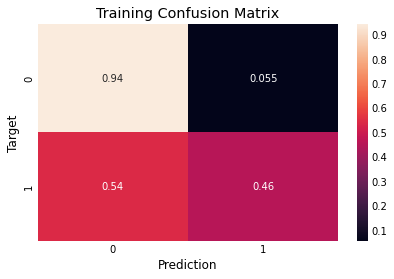

In [23]:
train_preds = predict_and_plot(X_train, y_train, 'Training')

Accuracy: 82.68%


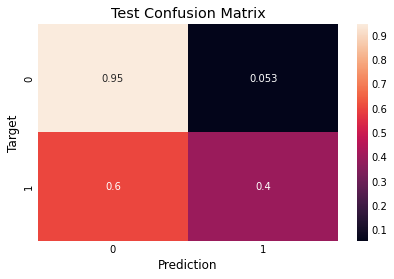

In [24]:
test_preds = predict_and_plot(X_test, y_test, 'Test')

In [25]:
df2.RainTomorrow.value_counts(normalize=True).round(3) * 100

No     77.8
Yes    22.2
Name: RainTomorrow, dtype: float64

## Check correlations

- RainToday - Rainfall corr : 1 No
- Sunshine - Evaporation cor : 0.8 No
- WindGustSpeed - WindGustDir : < 1 No
- WindSpeed3m -  WindDir3am: 0.8 NO
- Temp9am - Humidity9pm : 0.8 OK
- Temp3am - Humidity3am : 0.9 OK
- Pressure3pm - Pressure9am : < 1 OK
- cloud3pm -  cloud9pm: .8 NO

In [26]:
def check_correlation(df, ind, col):
  index, columns = df[ind], df[col]
  return pd.crosstab(index=index, columns=columns)

In [27]:
check_correlation(raw_df, 'Cloud3pm', 'Cloud9am')

Cloud9am,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Cloud3pm,,,,,,,,,,
0.0,3262,1073,188,93,53,58,53,92,46,0
1.0,2669,5450,1295,904,552,580,683,1107,668,0
2.0,590,1909,854,685,469,466,602,814,405,0
3.0,389,1566,751,745,424,562,658,1067,440,1
4.0,216,923,498,498,379,484,570,982,463,0
5.0,238,1078,519,619,491,673,839,1477,623,0
6.0,161,1015,670,707,543,791,1324,2496,1037,0
7.0,105,1179,809,902,744,1130,2055,8134,2757,0
8.0,28,344,260,262,297,403,692,2775,6544,0
